<a href="https://colab.research.google.com/github/erodola/DLAI-s2-2023/blob/main/labs/04/4_Logistic_Regression_and_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning

# Tutorial 6: MDS and t-SNE

In this tutorial, we will cover:

- Multi-dimensional scaling
- t-SNE

Authors:

- Prof. Emanuele Rodolà

Course:

- Lectures and notebooks at https://github.com/erodola/ML-s2-2025/

# Imports and utilities

In [1]:
# @title import dependencies

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import torch

In [2]:
# @title reproducibility stuff

import random
np.random.seed(42)
random.seed(0)

# Multi-Dimensional Scaling

Today we start simple! Our first goal is to reconstruct a square grid of 2D points, when given all the inter-point distances as input. Let's begin by building the 2D grid:

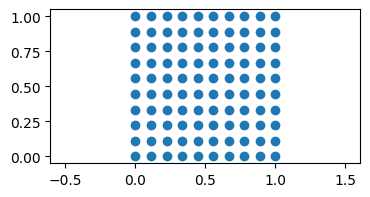

In [3]:
side = 10
n = side * side

pts = np.linspace(0, 1, side)
ptsx = pts[:, None] * np.ones((1, side))
ptsy = np.ones((side, 1)) * pts[None, :]
pts = np.column_stack([ptsx.reshape(-1), ptsy.reshape(-1)])

plt.figure(figsize=(4,2))
plt.scatter(pts[:, 0], pts[:, 1])
plt.axis('equal')
plt.show()

Now compute all the pairwise distances:

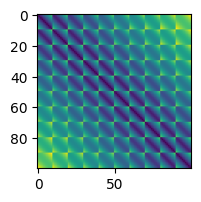

In [4]:
D = np.linalg.norm(pts[:, None] - pts[None, :], axis=-1)

plt.figure(figsize=(4,2))
plt.imshow(D)
plt.show()

At this point we are going to _forget about the coordinates of the 2D points_; imagine we lost this information, and we have to recover it from the distance matrix alone! This is one way of looking at multi-dimensional scaling (MDS): a recipe to recover (absolute) point coordinates from (relative) distances.

The MDS algorithm itself is not difficult. We need to minimize the metric distortion (_stress_), and we are going to do this with gradient descent. To refresh your memory, here's the optimization problem we are going to minimize:

$$ \min_\mathbf{Z} \| \mathbf{D} - D(\mathbf{Z}) \|_F^2 $$

where $\mathbf{D}$ is the $n \times n$ input matrix of pairwise distances, $\mathbf{Z} \in \mathbb{R}^{n\times k}$ are the $k$-dimensional points we are seeking to recover, and $D(\mathbf{Z})$ is the pairwise distance matrix computed from the recovered points. The gradient of this quadratic stress is given by:

$$ 2 \mathbf{VZ} - 2 B(\mathbf{Z})\mathbf{Z} $$

with

\begin{align}
\mathbf{V} &= n \mathbf{I} - \mathbf{11}^\top \\
B(\mathbf{Z}) &= -\mathbf{D} \oslash D(\mathbf{Z}) + \text{diag}( ( \mathbf{D} \oslash D(\mathbf{Z}) ) \mathbf{1} )
\end{align}

Let's bring the stress down!

> **EXERCISE:** Create a `mds` function taking as input the following parameters:
>
> - `D`: a $n\times n$ distance matrix
> - `k`: the desired target dimension of the embedded points
> - `lr`: the learning rate for gradient descent
> - `max_iter`: the maximum number of iterations for gradient descent
> - `tol`: a tolerance value to use as stop criterion for gradient descent
>
> The function must return a $n\times k$ matrix `Z` of points whose pairwise Euclidean distances are as close as possible to $\mathbf{D}$.

In [ ]:
# ✏️ your solution here
# def mds(...)

# test your solution with this call:
# Z = mds(D, 2, lr=2e-3, max_iter=1000, tol=1e-4)

In [5]:
# @title 👀 Solution

def mds(D,
        k: int,
        lr: float,
        max_iter: int,
        tol: float):

    n_ = D.shape[0]

    Z = np.random.rand(n_, k)

    V = n_ * np.eye(n_) - np.ones((n_, n_))

    if k == 2:
        plt.figure(figsize=(4,2))
        plt.scatter(Z[:, 0], Z[:, 1])
        plt.axis('equal')
        display(plt.gcf())

    stress = np.zeros(max_iter, dtype=np.float32)

    for i in range(max_iter):

        if k == 2:
            clear_output(wait=True)

        Dz = np.linalg.norm(Z[:, None] - Z[None, :], axis=-1)

        B = -D / (1e-8 + Dz)
        B = B + np.diag(-np.sum(B, axis=1))

        stress[i] = np.linalg.norm(D - Dz)**2

        if i > 0 and np.abs(stress[i] - stress[i-1]) < tol:
            stress = stress[:i]
            break

        grad = 2 * (V - B) @ Z
        Z -= lr * grad

        if k == 2:
            plt.clf()
            plt.scatter(Z[:, 0], Z[:, 1])
            plt.axis('equal')
            display(plt.gcf())

    plt.figure(figsize=(4,2))
    plt.plot(stress)
    plt.show()

    return Z

Can you recover the original 2D grid? Let's see:

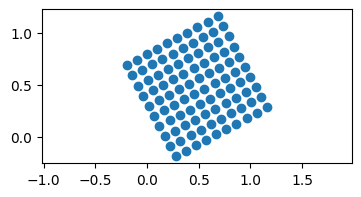

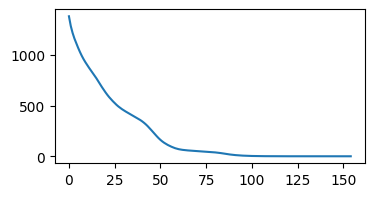

In [6]:
_ = mds(D, 2, lr=2e-3, max_iter=1000, tol=1e-4)

> **EXERCISE:** Why aren't we obtaining exactly the same grid we started with? Is something broken in our algorithm, or is this expected?

## Using autograd

Now, I know it was a bit painful to compute gradients by hand during the theory class, and it's quite likely that you went through some additional pain when implementing gradient descent correctly in the last exercise.

...But we could have just used **automatic differentiation** to solve our problem instead of doing everything by hand! Let's do this, and enjoy the simplicity of the new code.

> **EXERCISE:** Write a new function `mds_ad` that implements the same algorithm as `mds`, but using automatic differentiation instead of hand-written gradients. You can use the `torch` package for the autograd.

In [ ]:
# ✏️ your solution here

In [7]:
# @title 👀 Solution

def mds_ad(D,
           k: int,
           lr: float,
           max_iter: int,
           tol: float):

    n_ = D.shape[0]

    D_torch = torch.from_numpy(D)
    Z = torch.rand((n_, k), requires_grad=True)  # we need the gradient wrt Z

    if k == 2:
        with torch.no_grad():
            plt.figure(figsize=(4,2))
            plt.scatter(Z[:, 0], Z[:, 1])
            plt.axis('equal')
            display(plt.gcf())

    stress = torch.zeros(max_iter)

    for i in range(max_iter):

        if k == 2:
            clear_output(wait=True)

        Dz = torch.linalg.norm(Z[:, None] - Z[None, :], dim=-1)
        loss = torch.linalg.norm(D_torch - Dz)**2

        stress[i] = loss.item()

        if i > 0 and torch.abs(stress[i] - stress[i-1]) < tol:
            stress = stress[:i]
            break

        loss.backward()

        with torch.no_grad():
            Z -= lr * Z.grad
            Z.grad = None  # remember this to avoid gradient accumulation!

        if k == 2:
            with torch.no_grad():
                plt.clf()
                plt.scatter(Z[:, 0], Z[:, 1])
                plt.axis('equal')
                display(plt.gcf())

    plt.figure(figsize=(4,2))
    plt.plot(stress)
    plt.show()

    return Z

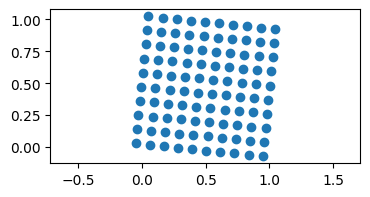

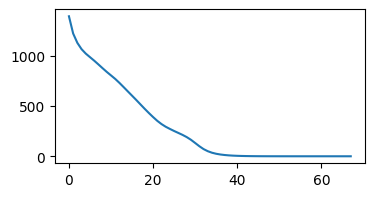

In [8]:
_ = mds_ad(D, 2, lr=2e-3, max_iter=1000, tol=1e-4)

## Dimensionality reduction

As we have seen, MDS is an embedding algorithm that can be used to recover point positions from their pairwise distances.

But it can do more than that! Since we can choose the number of dimensions in the embedding space, we can exploit this to do _dimensionality reduction_.

For example, let's embed our 2D grid into $\mathbb{R}$:

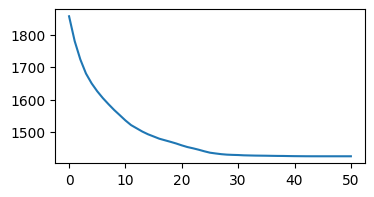

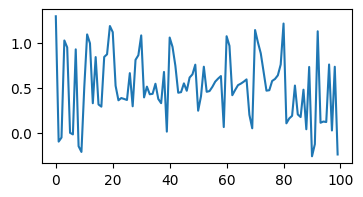

In [9]:
Z1d = mds(D, 1, lr=2e-3, max_iter=1000, tol=1e-10)

plt.figure(figsize=(4,2))
plt.plot(Z1d)
plt.show()

Hmm, this 1D embedding is not too easy to interpret. For example, what does it mean that point 80 has value 1.3?

Let's visualize this embedding in a different way.

> **EXERCISE:** Visualize the 1D embedding of the 2D grid as _colors_ for each point in the grid. For example, if point number 80 has value 1.3, then paint that point with a color proportional to 1.3 from the `jet` colormap.
>
> Once you have done this, how can you interpret the 1D embedding?

In [ ]:
# ✏️ your solution here

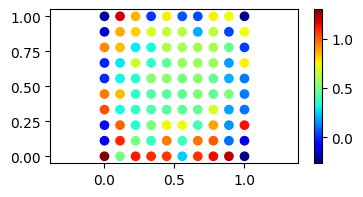

In [10]:
# @title 👀 Solution

plt.figure(figsize=(4,2))
sc = plt.scatter(pts[:, 0], pts[:, 1], c=Z1d, cmap='jet')
plt.colorbar(sc)
plt.axis('equal')
plt.show()

> **EXERCISE:** Take the small digits dataset from Scikit-learn and embed it in 2D using MDS. What results do you get? Can you spot any _clusters_ of different digits?

In [11]:
from sklearn.datasets import load_digits

digits = load_digits().data

# ✏️ your solution here

> **EXERCISE:** Using the same images from the previous exercise, use PCA to embed them in 2D. Compare with the result you got using MDS. From a qualitative perspective, what are the main differences?

In [12]:
from sklearn.datasets import load_digits

digits = load_digits().data

# ✏️ your solution here

# EXERCISE: t-SNE

We are now 2/3 through the ML course -- it's time to prove yourself a worthy ML practitioner! 🤓

Your task is to fill in this Section. In particular:

- Use markdown and code cells, as if you are writing this part of the notebook for your own students!
- You can use Scikit-learn's implementation of t-SNE, your own, or whatever you prefer.

The Section should include _at least_ the following experiments:

- Embed the small digit data into 2D using t-SNE.
- Embed the small digit data into 3D using t-SNE.
- Comment on the differences you observe between the two plots.
- Comment on the differences you observe with PCA and MDS embeddings in the same target space.
- Embed a _larger_ dataset into 2D using t-SNE, e.g. MNIST, or character emojis, or pokemon images... you choose it!
- Add whatever you think it's worth adding. If you think a t-SNE parameter needs further discussion, or some other aspect is worth discussing, feel free to do it!

[Here]() you can find a solution written by a fellow student from this course (a.y. 2023/2024). You can peek it for inspiration!

In [ ]:
# ✏️ start coding!